In [ ]:
import pandas as pd
import numpy as np

#import nltk
#nltk.download('stopwords')

from nltk.corpus import stopwords
stopwords = stopwords.words('english')

import torch as th
from torchtext.data import Field
from torchtext.data import Dataset
from torchtext.data import Example
from torchtext.data import BucketIterator

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from tqdm import tqdm

device = th.device('cuda' if th.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
train_df = pd.read_csv('data/processed_train.csv')
test_df = pd.read_csv('data/processed_test.csv')

In [ ]:
train_df['text'] = train_df['text'].str.replace('[^\w\s]','')
test_df['text'] = test_df['text'].str.replace('[^\w\s]','')

train_df['text'] = train_df['text'].str.split()
train_df['text'] = train_df['text'].apply(lambda x: [word for word in x if word not in stopwords])
train_df['text'] = train_df['text'].apply(lambda x: ' '.join(x))

test_df['text'] = test_df['text'].str.split()
test_df['text'] = test_df['text'].apply(lambda x: [word for word in x if word not in stopwords])
test_df['text'] = test_df['text'].apply(lambda x: ' '.join(x))

### Splitting training dataset for validation

In [ ]:
x = train_df['text'].values
y = train_df['label'].values

x_test = test_df['text'].values
y_test = test_df['label'].values

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2, stratify=y)

print('Train size: %i'%(len(x_train)))
print('Validation size: %i'%(len(x_val)))
print('Test size: %i'%(len(x_test)))

Train size: 20000
Validation size: 5000
Test size: 25000


### Creating Torch Datasets

In [ ]:
seq_len = 200
txt_field = Field(sequential=True,
                  fix_length=seq_len,
                  lower=True, 
                  pad_first=True, 
                  )

label_field = Field(sequential=False, use_vocab=False)

In [ ]:
preprocessed_train_text = [txt_field.preprocess(text) for text in x_train]

txt_field.build_vocab(preprocessed_train_text, vectors='glove.6B.100d')
vocab = txt_field.vocab

In [ ]:
train_dataset = Dataset([
                         Example.fromlist(list(row) , [('text', txt_field),
                                                       ('label', label_field)]) 
                         for row in zip(x_train, y_train)
                         ], 
                        [('text', txt_field), ('label', label_field)]
                        )
train_iter = BucketIterator(train_dataset, batch_size=8)

val_dataset = Dataset([
                       Example.fromlist(list(row) , [('text', txt_field),
                                                     ('label', label_field)]) 
                       for row in zip(x_val, y_val)
                       ], 
                      [('text', txt_field), ('label', label_field)]
                      )
val_iter = BucketIterator(val_dataset, batch_size=8)

test_dataset = Dataset([
                        Example.fromlist(list(row) , [('text', txt_field),
                                                     ('label', label_field)]) 
                        for row in zip(x_test, y_test)
                        ], 
                       [('text', txt_field), ('label', label_field)]
                       )
test_iter = BucketIterator(test_dataset, batch_size=32)

### Creating LSTM Model

In [ ]:
def decrease_lr(opt, epoch, init_lr):
  lr =  init_lr * (0.1 ** (epoch // 10))
  for param_group in opt.param_groups:
      param_group['lr'] = lr

In [ ]:
class Net(th.nn.Module):
  def __init__(self, 
               seq_len, 
               vocab, 
               emb_size,
               lstm_hidden, 
               lstm_layers,
               dropout):
    super(Net, self).__init__()

    self.seq_len = seq_len
    self.vocab = vocab
    self.emb_size = emb_size
    self.lstm_hidden = lstm_hidden
    self.lstm_layers = lstm_layers
    self.dropout = dropout
     
    self.emb = th.nn.Embedding(len(self.vocab)+1, self.emb_size)

    self.lstm = th.nn.LSTM(self.emb_size, 
                           self.lstm_hidden, 
                           self.lstm_layers, 
                           batch_first=True)
    
    self.fc = th.nn.Linear(self.lstm_hidden, 1)

    self.drop = th.nn.Dropout(self.dropout)
        
  def forward(self, x):
    emb_x = self.emb(x)

    h_state = th.zeros(self.lstm_layers, x.size(0), self.lstm_hidden).to(device)
    c_state = th.zeros(self.lstm_layers, x.size(0), self.lstm_hidden).to(device)
    hidden = (h_state, c_state)

    lstm_x, _ = self.lstm(emb_x, hidden)
    lstm_x = self.drop(lstm_x)
    lstm_x = lstm_x[:, -1, :]

    out = th.sigmoid(self.fc(lstm_x))    
    return out.view(-1)
    
  def predict(self, x):
    out = self.forward(x)
    return (out>.5).int()

In [ ]:
emb_size = 100
lstm_hidden = 32
lstm_layers = 3
dropout = .2

lr = 0.01
epochs = 30
early_stop_rounds = 10

net = Net(seq_len, 
          vocab, 
          emb_size, 
          lstm_hidden, 
          lstm_layers,
          dropout)
net = net.to(device)

opt = th.optim.Adam(net.parameters(), lr)
criterion = th.nn.BCELoss()

### Training Model

In [ ]:
losses = []
val_acc = []

early_stop_acc = -np.inf
early_stop_rounds_count = 0

for epoch in range(epochs):
  print('Epoch: %i'%(epoch+1))

  decrease_lr(opt, epoch, lr)

  net.train()

  batch_losses = []
  for train in tqdm(train_iter):
    txt = train.text.T.to(device)
    labels = train.label.to(device)

    output = net(txt)
    loss = criterion(output, labels.float())

    opt.zero_grad()
    loss.backward()
    opt.step()

    batch_losses.append(loss.item())

  loss_mean = np.array(batch_losses).mean()
  losses.append(loss_mean)
  print('LOSS: %f'%(loss_mean))

  if epoch % 5 == 0:
    path = 'models/lstm_model_checkpoint.pt'
    th.save({'epoch': epoch,
             'model_state_dict': net.state_dict(),
             'optimizer_state_dict': opt.state_dict(),
             'loss': loss_mean,
            }, path)
    
  net.eval()

  y_pred = []
  y_true = []

  for val in val_iter:
    val_txt = val.text.T.to(device)
    val_labels = val.label.to(device).cpu().numpy()

    y_true.extend(val_labels)
    y_pred.extend(net.predict(val_txt).cpu().numpy())

  acc = accuracy_score(y_true, y_pred)
  val_acc.append(acc)
  print('VALIDATION ACC: %.4f'%(acc))

  if acc > early_stop_acc:
    early_stop_acc = acc
    
    path = 'models/lstm_model_early_stop.pt'
    th.save({'epoch': epoch,
             'model_state_dict': net.state_dict(),
             'optimizer_state_dict': opt.state_dict(),
             'loss': loss_mean,
             'val_acc':acc
            }, path)
    
    early_stop_rounds_count = 0
  else:
    early_stop_rounds_count += 1

  if early_stop_rounds_count == early_stop_rounds:
    print('Early stopping...')
    print('Best acc:  %.4f'%(early_stop_acc))
    break

  0%|          | 4/2500 [00:00<01:09, 35.81it/s]

Epoch: 1


100%|██████████| 2500/2500 [00:55<00:00, 45.27it/s]


LOSS: 0.488450
VALIDATION ACC: 0.8242


  0%|          | 3/2500 [00:00<01:33, 26.79it/s]

Epoch: 2


100%|██████████| 2500/2500 [00:56<00:00, 44.26it/s]


LOSS: 0.253905
VALIDATION ACC: 0.8626


  0%|          | 3/2500 [00:00<01:23, 29.93it/s]

Epoch: 3


100%|██████████| 2500/2500 [00:55<00:00, 44.93it/s]


LOSS: 0.168601


  0%|          | 4/2500 [00:00<01:15, 33.15it/s]

VALIDATION ACC: 0.8610
Epoch: 4


100%|██████████| 2500/2500 [00:54<00:00, 45.59it/s]


LOSS: 0.125855


  0%|          | 4/2500 [00:00<01:06, 37.32it/s]

VALIDATION ACC: 0.8542
Epoch: 5


100%|██████████| 2500/2500 [00:56<00:00, 44.31it/s]


LOSS: 0.091087


  0%|          | 4/2500 [00:00<01:06, 37.74it/s]

VALIDATION ACC: 0.8474
Epoch: 6


100%|██████████| 2500/2500 [00:55<00:00, 44.91it/s]


LOSS: 0.072230


  0%|          | 4/2500 [00:00<01:07, 37.07it/s]

VALIDATION ACC: 0.8456
Epoch: 7


100%|██████████| 2500/2500 [00:55<00:00, 44.71it/s]


LOSS: 0.068656


  0%|          | 4/2500 [00:00<01:06, 37.82it/s]

VALIDATION ACC: 0.8494
Epoch: 8


100%|██████████| 2500/2500 [00:56<00:00, 44.50it/s]


LOSS: 0.050981


  0%|          | 4/2500 [00:00<01:07, 37.11it/s]

VALIDATION ACC: 0.8464
Epoch: 9


100%|██████████| 2500/2500 [00:56<00:00, 44.09it/s]


LOSS: 0.048866


  0%|          | 4/2500 [00:00<01:07, 37.15it/s]

VALIDATION ACC: 0.8436
Epoch: 10


100%|██████████| 2500/2500 [00:55<00:00, 44.80it/s]


LOSS: 0.043643


  0%|          | 4/2500 [00:00<01:07, 37.11it/s]

VALIDATION ACC: 0.8442
Epoch: 11


100%|██████████| 2500/2500 [00:55<00:00, 44.70it/s]


LOSS: 0.020248


  0%|          | 4/2500 [00:00<01:05, 38.06it/s]

VALIDATION ACC: 0.8474
Epoch: 12


100%|██████████| 2500/2500 [00:55<00:00, 44.94it/s]


LOSS: 0.007012
VALIDATION ACC: 0.8462
Early stopping...
Best acc:  0.8626


In [ ]:
early_stop_net = th.load('models/lstm_model_early_stop.pt')

net = Net(seq_len, 
          vocab, 
          emb_size, 
          lstm_hidden, 
          lstm_layers,
          dropout)
net = net.to(device)

net.load_state_dict(early_stop_net['model_state_dict'])

<All keys matched successfully>

### Model Evaluation

[Text(0, 0.5, 'Validation accuracy'), Text(0.5, 0, 'Epoch')]

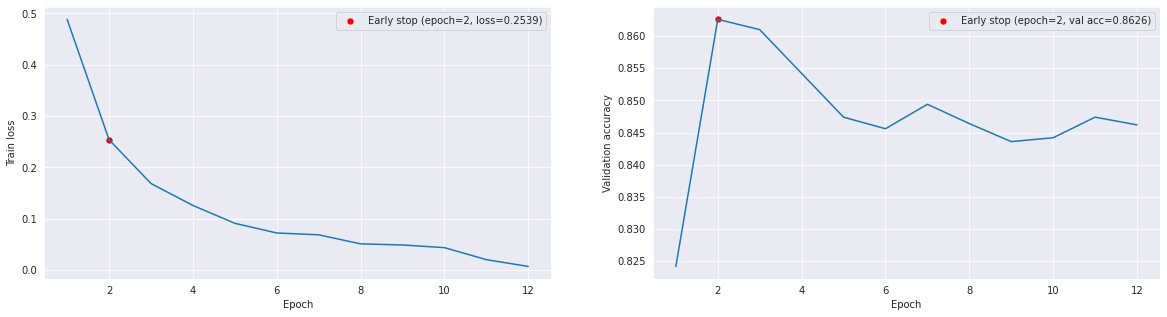

In [ ]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
ax = sns.scatterplot(x=[early_stop_net['epoch']+1], 
                     y=[early_stop_net['loss']], 
                     color='red', 
                     s=50)
ax.legend(['Early stop (epoch=%i, loss=%.4f)'%(early_stop_net['epoch']+1, 
                                               early_stop_net['loss'])])
ax = sns.lineplot(x=range(1, epoch+2), y=losses, ax=ax)

ax.set(xlabel='Epoch', ylabel='Train loss')

plt.subplot(1, 2, 2)
ax = sns.scatterplot(x=[early_stop_net['epoch']+1], 
                     y=[early_stop_net['val_acc']], 
                     color='red', 
                     s=50)
ax.legend(['Early stop (epoch=%i, val acc=%.4f)'%(early_stop_net['epoch']+1, 
                                               early_stop_net['val_acc'])])
ax = sns.lineplot(x=range(1, epoch+2), y=val_acc, ax=ax)
ax.set(xlabel='Epoch', ylabel='Validation accuracy')

              precision    recall  f1-score   support

           0    0.82857   0.85336   0.84078     12500
           1    0.84884   0.82344   0.83595     12500

    accuracy                        0.83840     25000
   macro avg    0.83870   0.83840   0.83836     25000
weighted avg    0.83870   0.83840   0.83836     25000



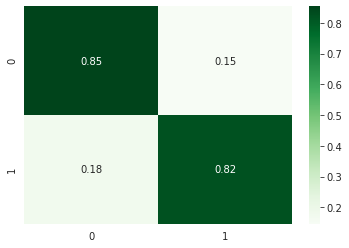

In [ ]:
y_pred = []
y_true = []
for test in test_iter:
  test_txt = test.text.T.to(device)
  test_labels = test.label.to(device).cpu().numpy()

  y_true.extend(test_labels)
  y_pred.extend(net.predict(test_txt).cpu().numpy())

print(classification_report(y_true, y_pred, digits=5))

cm = confusion_matrix(y_true, y_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap='Greens')